# Analytical Base Table

A Analytical Base Table (ABT), é a tabela analítica que é construída para treinar um modelo de machine learning. Cada registro deve representar uma entidade do problema que está sendo modelado e cada coluna uma feature da entidade, além de ter também uma coluna que será o target que queremos prever. 

Aqui iremos construir uma analytical base table para prever churn. Para isso, iremos utilizar os dados da [Olist disponíveis no Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) e iremos também construir a ABT utilizando `Pandas`. Caso queira uma outra discussão detalhada sobre construção de uma ABT de churn utilizando SQL ao invés de Pandas, recomendo fortemente um dos melhores conteúdos sobre machine learning na prática que existe, a playlista [DTona](https://www.youtube.com/watch?v=TNDiiVwQ5Vo&list=PLvlkVRRKOYFQOK176fl9bLjzFkvhIOSwu) no canal do youtube [Téo Me Why](https://www.youtube.com/channel/UC-Xa9J9-B4jBOoBNIHkMMKA).

Primeiro, vamos carregar as tabelas necessárias:

In [ ]:
#| eval: false
import dateutil
import numpy as np
import pandas as pd

In [ ]:
#| eval: false
df_order_items = pd.read_csv('../datasets/olist_order_items_dataset.csv')
df_orders = pd.read_csv('../datasets/olist_orders_dataset.csv', parse_dates=['order_approved_at'])
df_sellers = pd.read_csv('../datasets/olist_sellers_dataset.csv')

In [ ]:
#| eval: false
df_abt = pd.DataFrame()

for safra in pd.date_range('2017-03-01', '2018-03-01', freq='MS', normalize=True):
    data_ref_safra = pd.to_datetime(safra).date()
    data_inf_inclusiva = data_ref_safra - dateutil.relativedelta.relativedelta(months=12)
    data_sup_exclusiva = data_ref_safra + dateutil.relativedelta.relativedelta(months=6)

    # filtrando o período histórico
    df_historico = (
        df_order_items
        .merge(df_orders, on='order_id', how='left')
        .query(" order_status == 'delivered' ")
        .query(f"order_approved_at >= '{data_inf_inclusiva}' & order_approved_at < '{data_sup_exclusiva}' ")
        .merge(df_sellers, on='seller_id', how='left')
    )  

    # calculando as features
    df_features = (
        df_historico
        .query(f'order_approved_at < "{data_ref_safra}" ')
        .groupby('seller_id')
        .agg(
            uf = ('seller_state', 'first'),
            receita_12m = ('price', 'sum'),
            qtde_orders_12m = ('order_id', 'nunique'),
            qtde_items_12m = ('product_id', 'count'),
            qtde_items_dist_12m = ('product_id', 'nunique'),
            data_ult_vnd = ('order_approved_at', 'max')
        )
        .reset_index()
        .assign(data_ref = pd.to_datetime(f'{data_ref_safra}'))
        .assign(recencia = lambda df_: (df_['data_ref'] - df_['data_ult_vnd']).dt.days)
    )     

    # calculando o target
    df_target = (
        df_historico
        .query(f'order_approved_at >= "{data_ref_safra}" & order_approved_at < "{data_sup_exclusiva}" ')
        .filter(['seller_id'])
        .drop_duplicates()
    ) 

    # cruzando as features com o target: gerando a ABT
    df_abt_safra = (
        df_features
        .merge(df_target, how='left', on='seller_id', indicator=True)
        .assign(nao_revendeu_next_6m = lambda df_: np.where(df_['_merge'] == 'left_only', 1, 0))
        .assign(data_ref = lambda df_: df_['data_ref'].dt.date)
        .filter(['data_ref',
                 'seller_id',
                 'uf',
                 'receita_12m',
                 'qtde_orders_12m',
                 'recencia',
                 'qtde_items_12m',
                 'qtde_items_dist_12m',
                 'nao_revendeu_next_6m'
        ])
    )     

    df_abt = pd.concat([df_abt, df_abt_safra])  

# ABT Construída

In [ ]:
#| eval: false
df_abt

,data_ref,seller_id,uf,receita_12m,qtde_orders_12m,recencia,qtde_items_12m,qtde_items_dist_12m,nao_revendeu_next_6m
0,2017-03-01,001cca7ae9ae17fb1caed9dfb1094831,ES,899.10,4,0,9,1,0
1,2017-03-01,004c9cd9d87a3c30c522c48c4fc07416,SP,2629.31,17,1,20,15,0
2,2017-03-01,011b0eaba87386a2ae96a7d32bb531d1,SP,99.98,1,144,2,1,1
3,2017-03-01,014c0679dd340a0e338872e7ec85666a,MG,220.00,2,9,2,1,0
4,2017-03-01,01cf7e3d21494c41fb86034f2e714fa1,PR,992.90,8,4,8,3,0
...,...,...,...,...,...,...,...,...,...
1869,2018-03-01,ff82e8873fba613f2261a9acc896fd84,MG,124.60,4,12,4,3,1
1870,2018-03-01,ffc470761de7d0232558ba5e786e57b7,SP,385.59,5,0,5,5,0
1871,2018-03-01,ffdd9f82b9a447f6f8d4b91554cc7dd3,PR,1450.20,11,7,12,8,0
1872,2018-03-01,ffeee66ac5d5a62fe688b9d26f83f534,SP,1709.87,13,0,13,3,0


# Público e Churn no Tempo

Para cada seller em um período de tempo (safra), temos uma série de features que irá nos ajudar a prever o target `nao_revendeu_next_6m`.

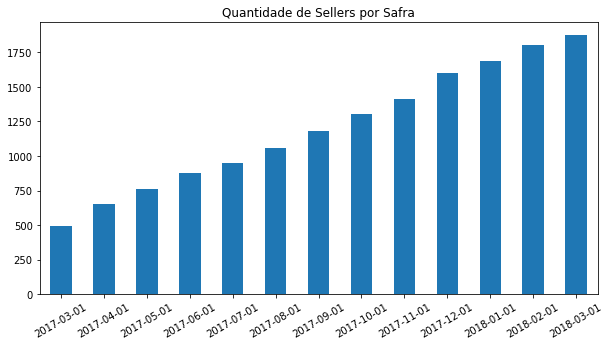

In [ ]:
#| eval: false
df_abt['data_ref'].value_counts(ascending=True).plot(kind='bar', title='Quantidade de Sellers por Safra', figsize=(10,5), rot=30);

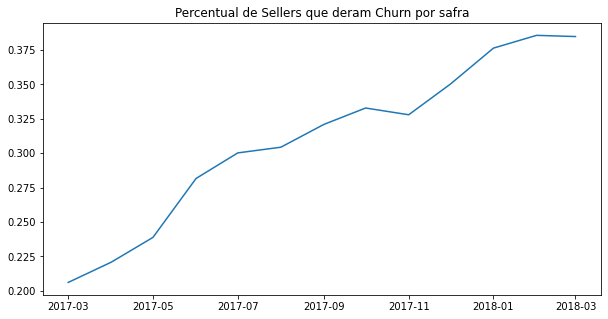

In [ ]:
#| eval: false
df_abt.groupby('data_ref')['nao_revendeu_next_6m'].mean().plot(title='Percentual de Sellers que deram Churn por safra', figsize=(10,5), xlabel='');

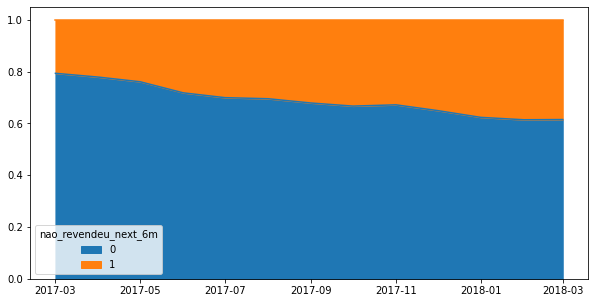

In [ ]:
#| eval: false
(df_abt.groupby(['data_ref', 'nao_revendeu_next_6m'])['nao_revendeu_next_6m'].size() / df_abt.groupby('data_ref').size()).unstack().plot(kind='area', figsize=(10,5), xlabel='');

De fato, o churn vem aumentando ao longo do tempo. Isso talvez seja esperado, dado que a operação da Olist em 2017-03 era bem recente e ali havíamos os primeiros clientes, chamados `early adopters`, que podem simplesmente ter testado o serviço e abandonado.

Como próximo passo, podemos já treinar um modelo de machine learning. Mas esse é um assunto para o próximo post, fique ligado!